<center>

# Anomaly Detection with Gate Model Quantum Computation

</center>

<br>

----

<br>


### Description

Anomaly detection is the identification of abnormal behavior in data, which manifests in individual data
points that differ significantly from the majority of
the data. This task frequently appears in many domains including finance,
medicine and telecommunications. A particularly challenging application of Anomaly Detection
can be found in Endpoint Detection and Response
(EDR), which aims at detecting and investigating suspicious activities on endpoints such as mobile phones
or workstations in cybersecurity. In
practice, the respective networks can be comprised of
billions of nodes, generating an immense amount of
data, in which the search for extremely scarce, malicious anomalies can be very tedious.
This vast number of typically high-dimensional
data points and additional impediments such as zeroday attacks raise a demand for suitable anomaly detection techniques deviating from the still widely used manual and rule-based approaches. While many
classical machine learning approaches to this mostly
unsupervised learning problem exist, the distinction between malicious and benign
anomalies frequently remains intractable due to insufficient generalization (Karami, 2018). This problem
substantiates in a trade-off between detecting an unacceptably high number of false positives (i.e., benign
data) and failing to reliably detect all true positives
(i.e., the malicious anomalies).

In the following notebook we demonstrate the application of Quantum Computing (QC)
to this problem, as QC has shown promising performance in generative data modelling, which is a popular technique used in unsupervised anomaly detection. Specifically, we implement the Quantum Boltzmann Machine algorithm implemented on a Gate model architecture for quantum computation.


### Gibbs state preparation
The training of QBMs involves the evaluation of Gibbs state expectation values, which is computationally intractable for classical computers due to the exponentially growing Hilbert space. However, this could be remedied through the usage of a quantum computer. One approach is to prepare a QBM on a quantum computer by leveraging the quantum eigenvalue transform (QEVT), a framework for realizing matrix polynomials on a quantum computer based on quantum signal processing (QSP).

The Gibbs state for the QBM is implemented by a numerical simulation of the QEVT suggested in [Dong, Y. *et al.*, *Efficient phase-factor evaluation in quantum signal processing*. *Physical Review A*, 103(4)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.103.042419). The necessary QSP phase factors are solved by interfacing with the [QSPPACK library](https://qsppack.readthedocs.io/). For the unitary block encoding of the QBM Hamiltonian, either a general unitary block encoding or the hardware-compatible LCU2 method is performed.


In [1]:
import os

import matplotlib.pyplot as plt
import random
from pennylane import numpy as np
from tqdm import tqdm
from qbmqsp.utils import construct_multi_fcqbm_pauli_strings
from qbmqsp.src.utils import import_dataset, split_dataset_labels, split_data
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
import scipy.linalg as spl
import pennylane as qml
from pennylane.pauli.utils import string_to_pauli_word


## Problem Specification, Toy Dataset

Simulating a gate-based QBM becomes unrealistic when the total number of nodes (hidden + visible) is of order 10. This is because the number of qubits required to prepare a Gibbs state using Quantum Signal Processing is of order $\mathbf{O}(2n+2)$. The dataset employed for demonstration of this use case is thus downsampled to a 2D pixelated dataset described below.  

<center>

We generate a synthetic dataset aimed at matching the following properties found in real-world data:  

- High dimensionality to assess scaling performance  
- Scarce anomalies  
- A substantial number of data points  

While (2) and (3) are straightforward, (1) is directly proportional to the number of visible units and thus the space complexity, compromising the achievable dimensionality. Compromising (1) to facilitate a visual evaluation and retain enough space for exploring a large space of hidden units for this first case study on fully unsupervised anomaly detection using a QBM, we restrict the dataset to three dimensions.  

To satisfy (2) and (3) within the limitations of current hardware capabilities, we generate **1007** 2D data points  
$x \in [0, \dots, 15]$  
clustered in five clusters and containing seven anomalies using the method `make_blobs` from scikit-learn (Pedregosa *et al.*, 2011).  

Therefore, seven bits are required per dimension, which means that **21 visible neurons** are needed to represent the QBM’s input, i.e., a single data point. Due to the 50/50 train/test split, the ratio of anomalies is  
$\leq \frac{7}{500} \approx 1\%$,  
satisfying (2). A pairplot of the generated dataset is displayed below.

The task is then to detect the outliers in an unsupervised manner such that the number of false positives remains fairly low.  

</center>


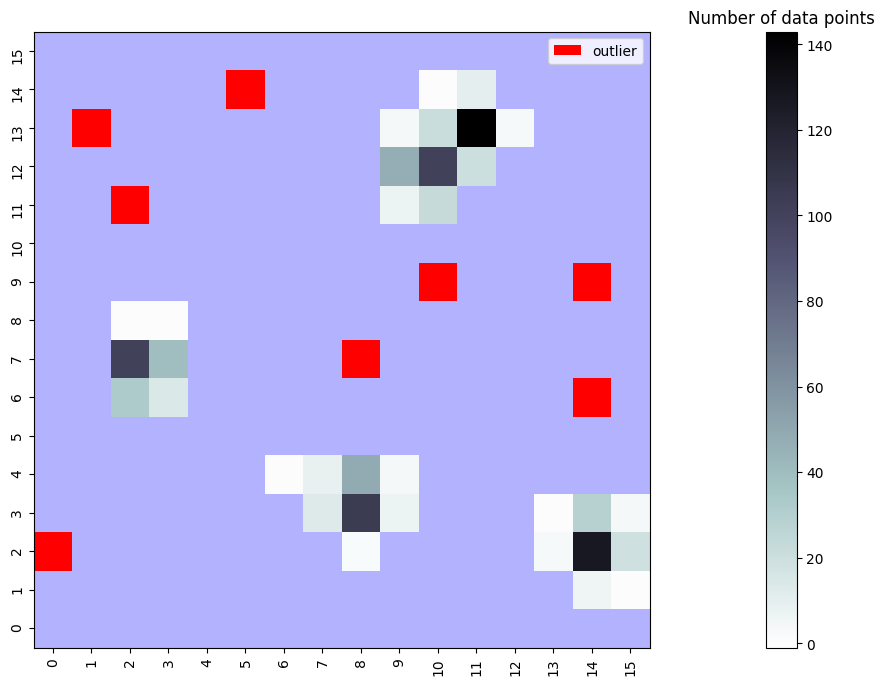

In [2]:
from qbmqsp import drawer


#----Loading the Dataset-------

#Specify Number of Clusters
CLUSTER=5

PATH= './qbmqsp/src/datasets/Gate_qbm_datasets/l_o8_c5_d2_v0.35_p190_4.npy'
np.random.seed(seed=3)
random.seed(3)
#dev_name='qiskit.ibmq'


data = import_dataset(PATH)
training_dataset, testing_dataset = split_data(data, CLUSTER)
training_data, training_labels = split_dataset_labels(training_dataset)
testing_data,testing_labels=split_dataset_labels(testing_dataset)


# Visualize Dataset

drawer.plot_pixel_dataset(data,CLUSTER)



## QBM's

A QBM is a machine learning model of the form of a variational Gibbs state [1].
$$ \rho_\theta = \frac{ e^{-\beta \hspace{0.05cm} H_\theta} }
                       { Tr {(e^{-\beta  \hspace{0.05cm} H_\theta})} } $$

where $H_\theta$ is a Hamiltonian parameterized by variational parameters $\theta$, acting on $n_v$ visible and $n_h$ hidden qubits.
 
$$
    H_\theta = \sum_{i=1}^{K} \theta_i h_i $$

where $\theta \in \mathbb{R}^K$ and $h_i = {\bigotimes}_{j=1}^{n} \hspace{0.1cm} \sigma_{j,i}$ with $\sigma_{j,i} \in \{ I, X, Y, Z \}$ and $n = n_v + n_h$. 
A QBM can be used for generative modeling of classical and quantum data and is trained using the POVM-based Golden-Thompson training.

A discrete target probability distribution $Q$, specified by probabilities $\{q^{v}\}$, and a POVM $\{\Uplambda_{v} \otimes I_h\}$ acting non-trivially only on the visible subsystem. 
We optimize the QBM such that the probability distribution $P_\theta$ defined by the outcome probabilities $p^{v}_\theta = Tr{(\Uplambda{v} \otimes I_h) \rho_\theta}$ of a POVM measurement specified by $\{\Uplambda{v}\}$ on $\rho_\theta$, is as close as possible to $Q$.
This is achieved by minimizing the Kullback-Leibler divergence ${D_{\text{KL}} (Q \Vert P_{\theta}) = \sum_{v} q^{v} \log \left( \frac{q^{v}}{p^{v}_\theta} \right)}$ via gradient descent. 

$$
     \partial_{\theta_i} D_{\text{KL}} (Q \Vert \widetilde{P}_{\theta}) 
    = 
    \overline{\langle \partial_{\theta_i} H_\theta^{v}  \rangle}_{v} 
    - 
    \langle \partial_{\theta_i} H_\theta  \rangle_{\rho_\theta} $$

where 
$$ 
    \overline{\langle \hspace{0.1cm} \boldsymbol{\cdot} \hspace{0.1cm} \rangle}_{v}
    = 
    \sum_v q^{v} \hspace{0.05cm} \langle \hspace{0.1cm} {\cdot} \hspace{0.1cm} \rangle_{v}
    = 
    \sum_{v} q^{v} \hspace{0.05cm} Tr({
    \frac{ 
    e^{-\beta H_\theta^{v}} }
    { Tr({e^{-\beta H_\theta^{v}}} }) \hspace{0.1cm} {\cdot} \hspace{0.1cm}
    } $$
For the Hamiltonian of the form that is implemented in Quantum Annealers:


$$
    %H_{(\Upgamma,\, b,\, w)} 
    H_{\theta}
    = 
    - \sum_i \Upgamma_i \sigma^x_i - \sum_i b_i \sigma^z_i - \sum_{ij} w_{ij} \sigma^z_i \sigma^z_j $$

The weights updates then take the form :
$$ \delta b_i= \overline{\langle \sigma^z_i \rangle_v} - \langle\sigma^z_i \rangle$$
$$ \delta w_{ij} = \overline{\langle \sigma^z_i \sigma^z_j\rangle_v} - \langle\sigma^z_i\sigma^z_j \rangle$$


### Quantum Signal Processing

As a mixed quantum state, the QBM is not prepared directly, but rather a **purification** of it.  
Given an $n$-qubit QBM, we define two $n$-qubit registers: the system register $S$ and the environment register $E$, to prepare  
$\ket{\phi^{+}}_{S,E}^{\otimes n}$,  
where  
$\ket{\phi^{+}}_{S,E} = (\ket{00} + \ket{11}) / \sqrt{2}$  
denotes the maximally entangled state with the first qubit in $S$ and the second qubit in $E$.  

We then apply  
$V_\theta = e^{- \frac{\beta}{2} \, H_\theta}$  
and perform measurements in $S$ but not in $E$, i.e., we trace out $E$, resulting in a QBM:

$$
\operatorname{Tr}_{E} \!\left[ \, (V_\theta \otimes I_E) \, 
\ket{\phi^{+}}\bra{\phi^{+}}_{S,E}^{\otimes n} \,
(V_\theta^{\dagger} \otimes I_E) \, \right]
= \rho_\theta \, .
$$

To apply the non-unitary, imaginary-time evolution operator $V_\theta$, we utilize **QEVT**.  

**1.** – We perform a **unitary block encoding** of the Hamiltonian, which requires a third register: the auxiliary register $A$. This project implements  
the general encoding scheme  
$Z \otimes H_\theta + X \otimes \sqrt{I - H_\theta^2}$  
and the hardware-compatible **LCU**[^2] method.  

**2.** – We find the **QSP phase factors** to realize $e^{- \frac{\beta}{2} \, x}$ on a quantum computer.  
Since the QSP theorem only allows for realizing polynomials of definite parity, we compute the QSP phase factors $\varphi$ for a polynomial approximation of the even function  
$f_\tau (x) = e^{- \tau \, |x|}$  
for some $\tau \in \mathbb{R}$.  
This is achieved by interfacing with **QSPPACK**, which finds a polynomial approximation of $f_\tau$ on an interval $[\delta, \, 1]$ for some tunable parameter $\delta \in (0, 1)$.

Hence, to realize $V_\theta$, we must scale the spectrum of $H_\theta$ to the interval $[\delta, \, 1]$.  
Since $H_\theta$ is a linear combination of Pauli string operators (with eigenvalues $\pm 1$), the operator norm is bounded by  
$\lVert H_\theta \rVert \le \lVert \theta \rVert_1$.  
Therefore, the preprocessing

$$
H_\theta^\delta = 
\frac{ H_\theta + \lVert \theta \rVert_1 \, I }
     { 2 \lVert \theta \rVert_1 } (1 - \delta)
     + \delta \, I
$$

(where $I$ denotes the identity operator) results in  
$\operatorname{spec}( H_\theta^{\delta} ) \subset [\delta, 1]$.  

By computing $\varphi$ for $f_\tau$ with  
$\tau = \frac{ \beta \, \lVert \theta \rVert_1 }{ 1 - \delta }$  
and employing QEVT, we implement a unitary $U_\varphi$ acting on $A$ and $S$ such that

$$
(\bra{0}_A \otimes I_S) \, U_\varphi \, (\ket{0}_A \otimes I_S)
= f_\tau(H_{\theta}^{\delta})
= e^{- \tau \, H_{\theta}^{\delta}}
= V_\theta \, e^{ - \beta \, \frac{1 + \delta}{1 - \delta} \, \lVert \theta \rVert_1 } \, .
$$

Hence, by preparing the state  
$\ket{0}_{A} \otimes \ket{\phi^{+}}_{S,E}^{\otimes n}$,  
applying $U_\varphi$ on $A$ and $S$, and measuring $\ket{0}_A$ in $A$ (while performing any measurement on system $S$ but not $E$), we obtain the statistics of a QBM:

$$
\operatorname{Tr}_{E} \!\left[ (\bra{0}_A \otimes I_S) \,
U_\varphi \,
( \ket{0}\bra{0}_A \otimes \ket{\phi^{+}}\bra{\phi^{+}}_{S,E}^{\otimes n} ) \,
U_\varphi^{\dagger} \,
(\ket{0}_A \otimes I_S) \right]
\sim \rho_\theta \, .
$$

The **normalization factor** is the trace of the LHS, equivalent to the success probability of measuring $\ket{0}_A$ in $A$:

$$
p_0 = \operatorname{Tr}\!\left[ e^{- \beta H_\theta} \right] \, 2^{-n} \, e^{ - \beta \, \frac{1 - \delta}{1 + \delta} \, \lVert \theta \rVert_1 } \, ,
$$

which can be increased by employing amplitude amplification in system $A$.

![Gibbs Diagram](images/qevt.png)


## Training and Testing the QBM

The training for the QBM could be time-consuming compared to the model hyper-parameters, the model here can be trained in reasonable time if hidden units are 0 or 1. 

### Training a fully visible QBM



In [3]:
from qbmqsp.gate_qbm  import QBM
import numpy
#training_data=numpy.expand_dims(training_data[:,0],axis=1)
#training_data=training_data[0::]

n_hidden_units=0
n_visible=8
n_qubits = n_visible+n_hidden_units
restricted=False
multiple=True   # set True for 3-qubit-interaction terms
enc = 'general'
δ = 0.3
polydeg = 10
β = 1.8467804429088952
learning_rate = 0.2187183103085994
epochs = 1
batch_size=53
seed=121


dev_name='default.qubit'
#dev_name='lightning.qubit'
qbm = QBM(training_data,enc, δ, polydeg, β,n_hidden_units,epochs,restricted,multiple=multiple)





Starting MATLAB engine.. 

C:\Users\arora\anaconda3\envs\qbmqsp\Lib\site-packages\pennylane\operation.py:2622: PennyLaneDeprecationWarning: Observable is deprecated and will be removed in v0.43. A generic Operator class should be used instead. If defining an Operator, set the is_hermitian property to True. If checking if an Operator is Hermitian, check the is_hermitian property. 
  warnings.warn(


Done.



In [4]:

errors,weights=qbm.train_model(batch_size,learning_rate)


Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.72s/it]


### Evaluation of the Model

The model is evaluated for the test dataset. The predicted outliers are shown in <span style="color:red;">red</span>.


Outlier threshold:  -0.7078996045517361
Calculate outlier Energy


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 162.98it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 475/475 [00:01<00:00, 268.86it/s]
C:\Users\arora\Downloads\QAR\QAR\Gate_qbm\qbmqsp\gate_qbm.py:216: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=testing_data[:,0][testing_labels>lab],y=testing_data[:,1][testing_labels>lab], c='r',palette='coolwarm')


Outlier classification: Results...
Accuracy: 0.9478079331941545, Precision: 0.1111111111111111, Recall: 0.75, F1-Score: 0.1935483870967742, 
Num True Negative: 451, Num False Negative: 1, Num True Positive: 3, Num False Positive: 24
Outlier threshold:  -0.7078996045517361
Average clusterpoint energy:  -16.876832831755483
Outlier energy:  [ 5.15768137 -2.84338427  3.17223714  2.39727472]


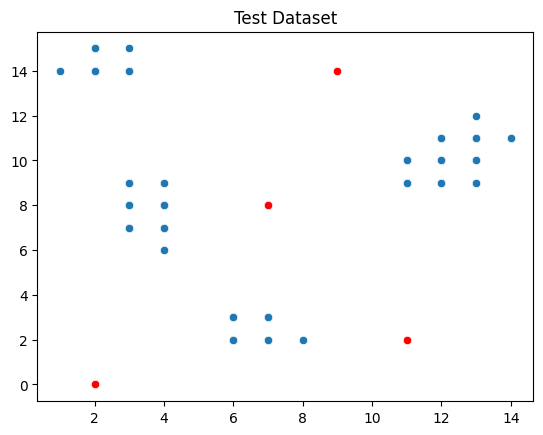

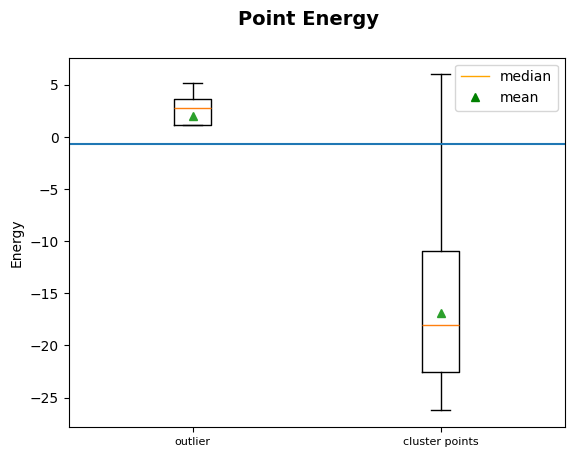

In [5]:
from qbmqsp.gate_qbm import evaluate_qbm

precision,recall,f1,energy_data=evaluate_qbm(qbm,testing_dataset,CLUSTER,quantile=0.95,plot=True)

### Sources


[1] [Amin, M. , Andiyash, E. , Rolfe,J. , Kulchytskyy, B. & Melko, R. (2018). Quantum Boltzmann Machine. Phys. Rev. X,  8.](https://link.aps.org/doi/10.1103/PhysRevX.8.021050)

[2] [Stein, J. , Schuman, D. , et al. (2024). Exploring Unsupervised Anomaly Detection with Quantum Boltzmann Machines in Fraud Detection. Proceedings of the 16th International Conference on Agents and Artificial Intelligence, SCITEPRESS](https://dx.doi.org/10.5220/0012326100003636) 

[3] [Dong, Y. et al., Efficient phase-factor evaluation in quantum signal processing. Physical Review A, 103(4)](https://doi.org/10.1103/PhysRevA.103.042419)

**Package for QSP:**  
QSPPACK: A toolbox for solving phase factors in Quantum Signal Processing. Available at [https://github.com/qsppack/QSPPACK](https://github.com/qsppack/QSPPACK)